# Growth modes

In [1]:
!make -C .. breakpoints

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'breakpoints'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import swisslandstats as sls
from scipy import ndimage as ndi

from swiss_urbanization import settings, utils

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

In [3]:
agglom_slugs = ['bern', 'lausanne', 'zurich']

urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

base_mask_dict = settings.BASE_MASK_DICT
base_mask_crs = settings.BASE_MASK_CRS
max_buffer_dist = settings.MAX_BUFFER_DIST

In [4]:
agglom_extent_dict = {}
agglom_inner_dict = {}
agglom_outer_dict = {}

for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes, dates = utils.get_landscapes_and_dates(ldf, nodata)
    with open(f'../data/processed/breakpoints/{agglom_slug}.json') as fp:
        agglom_bkps = json.load(fp)    
    agglom_extent_dict[agglom_slug] = pls.SpatioTemporalAnalysis(landscapes,
                                                                 dates=dates)
    agglom_stba = pls.SpatioTemporalBufferAnalysis(
        landscapes,
        base_mask_dict[agglom_slug],
        buffer_rings=True,
        buffer_dists=[agglom_bkps[-1], max_buffer_dist],
        base_mask_crs=base_mask_crs,
        landscape_crs=ldf.crs,
        landscape_transform=ldf.get_transform(),
        dates=dates)
    agglom_inner_dict[agglom_slug] = agglom_stba.stas[0]
    agglom_outer_dict[agglom_slug] = agglom_stba.stas[-1]    

In [5]:
kernel_moore = ndi.generate_binary_structure(2, 2)


def new_patches_label(landscape_base_arr, landscape_prime_arr, urban_class):
    new_patches_arr = (landscape_prime_arr == urban_class) & \
                      (landscape_base_arr != urban_class)
    return ndi.label(new_patches_arr, kernel_moore)


def compute_patch_areas(label_arr):
    return np.bincount(label_arr.ravel())[1:]


def compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                       urban_class, nonurban_class):
    patch_leis = []
    for k in range(1, num_patches + 1):
        patch_arr = label_arr == k
        buffer_zone_arr = ndi.binary_dilation(patch_arr,
                                              kernel_moore) & ~patch_arr
        buffer_classes = landscape_prime_arr[buffer_zone_arr]
        area_urban = np.sum(buffer_classes == urban_class)
        area_nonurban = np.sum(buffer_classes == nonurban_class)
        patch_leis.append(area_urban / (area_urban + area_nonurban))

    return patch_leis

In [6]:
def area_weighted_count(patch_areas, cond):
    return np.sum(patch_areas[cond]) / np.sum(patch_areas)


def plot_growth_modes(sta,
                      urban_class,
                      nonurban_class,
                      weight='number',
                      ax=None,
                      subplots_kws={}):
    if ax is None:
        fig, ax = plt.subplots(**subplots_kws)

    t_range = range(len(sta) - 1)
    # grouped bar plot idea from Chris Albon https://bit.ly/2JrybQ5
    pos = list(t_range)
    width = .25

    leapfrogs = np.zeros(len(t_range))
    edge_expansions = np.zeros(len(t_range))
    infills = np.zeros(len(t_range))
    for t in t_range:
        landscape_base_arr = sta.landscapes[t].landscape_arr
        landscape_prime_arr = sta.landscapes[t + 1].landscape_arr
        label_arr, num_patches = new_patches_label(landscape_base_arr,
                                                   landscape_prime_arr,
                                                   urban_class)
        patch_leis = np.array(
            compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                               urban_class, nonurban_class))

        leapfrog_cond = np.isclose(patch_leis, 0)
        edge_expansion_cond = (patch_leis > 0) & (patch_leis <= .5)
        infill_cond = patch_leis > .5

        if weight == 'number':
            leapfrog = np.sum(leapfrog_cond) / num_patches
            edge_expansion = np.sum(edge_expansion_cond) / num_patches
            infill = np.sum(infill_cond) / num_patches
        else:  # 'area'
            patch_areas = compute_patch_areas(label_arr)
            leapfrog = area_weighted_count(patch_areas, leapfrog_cond)
            edge_expansion = area_weighted_count(patch_areas,
                                                 edge_expansion_cond)
            infill = area_weighted_count(patch_areas, infill_cond)

        leapfrogs[t] = leapfrog
        edge_expansions[t] = edge_expansion
        infills[t] = infill

    print('leapfrog: ', leapfrogs)
    print('edge expansion: ', edge_expansions)
    print('infilling: ', infills)
    ax.bar(pos, leapfrogs * 100, width, label='leapfrog')
    ax.bar([p + width for p in pos],
           edge_expansions * 100,
           width,
           label='edge-expansion')
    ax.bar([p + 2 * width for p in pos],
           infills * 100,
           width,
           label='infilling')

    if weight == 'number':
        ax.set_ylabel('% patch number')
    else:  # 'area'
        ax.set_ylabel('% area')
    ax.set_xticks([p + width for p in pos])
    ax.set_xticklabels(
        ['{}-{}'.format(sta.dates[t], sta.dates[t + 1]) for t in t_range])
    ax.legend()

    return ax

Bern

Agglomeration extent


leapfrog:  [0.11655874 0.13157895 0.14616498]
edge expansion:  [0.62442183 0.58881579 0.53256151]
infilling:  [0.25901943 0.27960526 0.32127352]

Inner zone


leapfrog:  [0.015625 0.       0.      ]
edge expansion:  [0.171875   0.19607843 0.22727273]
infilling:  [0.8125     0.80392157 0.77272727]

Outer zone


leapfrog:  [0.12389381 0.13969732 0.15838509]
edge expansion:  [0.64503441 0.61001164 0.54968944]
infilling:  [0.23107178 0.25029104 0.29192547]

Lausanne

Agglomeration extent


leapfrog:  [0.12040816 0.1582015  0.10469314]
edge expansion:  [0.58095238 0.58368027 0.54753309]
infilling:  [0.29863946 0.25811823 0.34777377]

Inner zone


leapfrog:  [0.         0.01851852 0.        ]
edge expansion:  [0.38938053 0.14814815 0.10204082]
infilling:  [0.61061947 0.83333333 0.89795918]

Outer zone


leapfrog:  [0.128782   0.16311399 0.10848401]
edge expansion:  [0.58494957 0.59777572 0.56884562]
infilling:  [0.28626843 0.23911029 0.32267038]

Zurich

Agglomeration extent


leapfrog:  [0.09182707 0.0558109  0.08531746]
edge expansion:  [0.51656674 0.47307945 0.44444444]
infilling:  [0.39160618 0.47110965 0.4702381 ]

Inner zone


leapfrog:  [0.02507837 0.00401606 0.02205882]
edge expansion:  [0.31034483 0.29317269 0.35294118]
infilling:  [0.6645768  0.70281124 0.625     ]

Outer zone


leapfrog:  [0.09435666 0.05122393 0.09056244]
edge expansion:  [0.53047404 0.47688123 0.45185891]
infilling:  [0.3751693  0.47189483 0.45757865]



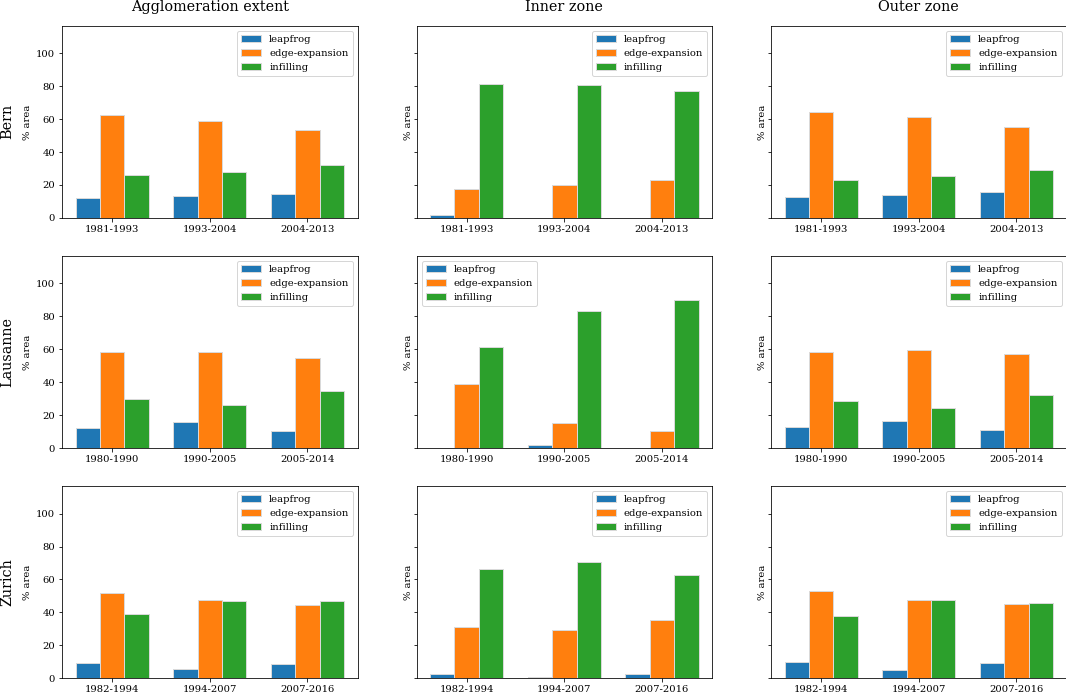

In [7]:
num_cols = 3
num_rows = len(agglom_slugs)

extents = ('Agglomeration extent', 'Inner zone', 'Outer zone')

fig, axes = plt.subplots(num_rows,
                         num_cols,
                         sharey=True,
                         figsize=(num_cols * figwidth, num_rows * figheight))
for agglom_slug, axs in zip(agglom_slugs, axes):
    print(f'{agglom_slug.capitalize()}')
    for agglom_dict, extent, ax in zip(
        (agglom_extent_dict, agglom_inner_dict, agglom_outer_dict), extents, axs):
        agglom_sta = agglom_dict[agglom_slug]
        print(f'\n{extent}')
        plot_growth_modes(agglom_sta,
                          urban_class,
                          nonurban_class,
                          weight='area',
                          ax=ax)
        ax.margins(y=.3)
    print()  # breakline

for ax, extent in zip(axes[0], extents):
    ax.set_title(extent, fontsize='x-large', pad=15)

for ax, agglom_slug in zip(axes[:, 0], agglom_slugs):
    ax.annotate(agglom_slug.capitalize(),
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label,
                textcoords='offset points',
                size='x-large',
                ha='right',
                va='center', rotation='vertical')

fig.savefig('../reports/figures/growth_modes.eps')